In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Changing the directory
%cd '/content/drive/MyDrive/DSGP'

/content/drive/MyDrive/DSGP


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16


In [ ]:
def load_data_split(base_dir):
    """
    Loads images.npy and masks.npy from the given folder.

    Parameters:
    -----------
    base_dir : str
        Path to the folder containing 'images.npy' and 'masks.npy'.

    Returns:
    --------
    images : np.ndarray
        Shape: (N, H, W, 3).
    masks : np.ndarray
        Shape: (N, H, W).
    """
    images_path = os.path.join(base_dir, "images.npy")
    masks_path = os.path.join(base_dir, "masks.npy")
    images = np.load(images_path)
    masks = np.load(masks_path)
    return images, masks


In [ ]:
def preprocess_images_masks(images, masks, is_binary=True):
    """
    Converts images to float32 and scales to [0..1].
    For binary segmentation, ensures masks are 0 or 1.
    Finally, expands mask dims to (H, W, 1) to be compatible
    with tf.image flipping operations.

    Parameters:
    -----------
    images : np.ndarray
        Shape: (N, H, W, 3), typically in [0..255].
    masks : np.ndarray
        Shape: (N, H, W), with values {0,255} or {0,1}, etc.
    is_binary : bool
        Whether to binarize the masks (for binary segmentation).

    Returns:
    --------
    images_out : np.ndarray
        Shape: (N, H, W, 3) in float32, scaled to [0..1].
    masks_out : np.ndarray
        Shape: (N, H, W, 1), float32, binarized if is_binary=True.
    """
    # Convert images to float32 and normalize to 0..1
    images_out = images.astype("float32") / 255.0

    # Convert masks to float32
    masks_out = masks.astype("float32")

    if is_binary:
        # Ensure masks are only 0 or 1
        masks_out[masks_out > 0] = 1.0

    # Expand dims for flipping: (H, W) -> (H, W, 1)
    masks_out = np.expand_dims(masks_out, axis=-1)

    return images_out, masks_out


In [ ]:
def random_augment(img, mask):
    """
    Example augmentation function:
      - 50% chance horizontal flip
      - slight random brightness for the image

    img shape: (H, W, 3)
    mask shape: (H, W, 1)
    """
    # Random horizontal flip
    if tf.random.uniform([]) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Random brightness (on the image only)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img, mask


def build_dataset(images, masks, batch_size=4, augment=False, shuffle=True):
    """
    Creates a tf.data.Dataset from NumPy arrays, with optional augmentation.

    Parameters:
    -----------
    images : np.ndarray
        Shape: (N, H, W, 3).
    masks : np.ndarray
        Shape: (N, H, W, 1).
    batch_size : int
        How many samples per batch.
    augment : bool
        Whether to apply random_augment.
    shuffle : bool
        Whether to shuffle the dataset.

    Returns:
    --------
    tf.data.Dataset ready for training or validation.
    """
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)
    if augment:
        ds = ds.map(lambda x, y: random_augment(x, y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
def fcn_8(num_classes=1, input_shape=(512, 512, 3)):
    """
    Build an FCN-8 model for semantic segmentation using a VGG16 encoder.

    Parameters:
    -----------
    num_classes : int
        1 for binary seg (final activation=sigmoid),
        >1 for multi-class seg (final activation=softmax).
    input_shape : tuple
        (height, width, channels). Should match your data.

    Returns:
    --------
    model : tf.keras.Model
        A Keras model instance of FCN-8.
    """
    # --------------------------
    # 5.1 Encoder (VGG16)
    # --------------------------
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Intermediate feature maps for skip connections
    pool3 = vgg.get_layer("block3_pool").output  # (H/8,  W/8,  256)
    pool4 = vgg.get_layer("block4_pool").output  # (H/16, W/16, 512)
    pool5 = vgg.get_layer("block5_pool").output  # (H/32, W/32, 512)

    # --------------------------
    # 5.2 Decoder
    # --------------------------
    # 1x1 conv on pool5
    score_pool5 = layers.Conv2D(num_classes, (1,1), padding='same',
                                name='score_pool5')(pool5)

    # Upsample 2x => combine with pool4
    up_pool5 = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2,
                                      padding='same', use_bias=False,
                                      name='up_pool5')(score_pool5)
    score_pool4 = layers.Conv2D(num_classes, (1,1), padding='same',
                                name='score_pool4')(pool4)
    add_pool4 = layers.Add(name='add_pool4')([up_pool5, score_pool4])

    # Upsample 2x => combine with pool3
    up_pool4 = layers.Conv2DTranspose(num_classes, kernel_size=4, strides=2,
                                      padding='same', use_bias=False,
                                      name='up_pool4')(add_pool4)
    score_pool3 = layers.Conv2D(num_classes, (1,1), padding='same',
                                name='score_pool3')(pool3)
    add_pool3 = layers.Add(name='add_pool3')([up_pool4, score_pool3])

    # Final upsample 8x
    up_final = layers.Conv2DTranspose(num_classes, kernel_size=16, strides=8,
                                      padding='same', use_bias=False,
                                      name='up_final')(add_pool3)

    # --------------------------
    # 5.3 Output Activation
    # --------------------------
    if num_classes == 1:
        # Binary segmentation
        x = layers.Activation('sigmoid', name='pred_mask')(up_final)
    else:
        # Multi-class segmentation
        x = layers.Activation('softmax', name='pred_mask')(up_final)

    # Build model
    model = Model(inputs=vgg.input, outputs=x, name="FCN-8")
    return model


In [ ]:
def train_fcn8(
    train_ds,
    val_ds,
    input_shape=(512, 512, 3),
    num_classes=1,
    learning_rate=1e-4,
    epochs=20
):
    """
    Compiles and trains an FCN-8 model on the given train and validation datasets.

    Parameters:
    -----------
    train_ds : tf.data.Dataset
        Training dataset (images+labels) in batches.
    val_ds : tf.data.Dataset
        Validation dataset (images+labels) in batches.
    input_shape : tuple
        Model input shape. e.g. (512, 512, 3).
    num_classes : int
        1 => binary seg, >1 => multi-class seg.
    learning_rate : float
        Optimizer learning rate.
    epochs : int
        Number of epochs to train.

    Returns:
    --------
    model : tf.keras.Model
        The trained FCN-8 model.
    history : History object
        Training history with losses and metrics.
    """
    # Instantiate FCN-8
    model = fcn_8(num_classes=num_classes, input_shape=input_shape)

    # (Optional) Freeze early layers if your dataset is small
    # for layer in model.layers[:10]:
    #     layer.trainable = False

    # Compile
    if num_classes == 1:
        # Binary segmentation
        loss = 'binary_crossentropy'
    else:
        # Multi-class segmentation
        loss = 'sparse_categorical_crossentropy'

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=['accuracy']
    )

    # Train
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds
    )

    return model, history


In [ ]:
def evaluate_model(model, test_ds):
    """
    Evaluates the model on the test dataset.

    Parameters:
    -----------
    model : tf.keras.Model
        A trained segmentation model.
    test_ds : tf.data.Dataset
        Test dataset (images+labels) in batches.

    Returns:
    --------
    test_loss : float
    test_acc : float
    """
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc


def predict_and_threshold(model, img_batch, threshold=0.5):
    """
    Performs inference on a batch of images and applies a threshold
    to convert probabilities to binary masks (for binary segmentation).

    Parameters:
    -----------
    model : tf.keras.Model
        A trained segmentation model (binary).
    img_batch : np.ndarray or tf.Tensor
        Shape: (batch_size, H, W, 3).
    threshold : float
        Probability threshold for binarizing predictions.

    Returns:
    --------
    preds_binary : np.ndarray
        Shape: (batch_size, H, W, 1), with values {0,1}.
    """
    preds = model.predict(img_batch)  # shape: (batch_size, H, W, 1)
    preds_binary = (preds > threshold).astype("uint8")
    return preds_binary


In [ ]:
if __name__ == "__main__":
    # 8.1 Load the data
    train_images, train_masks = load_data_split("split_dataset/training/numpy")
    val_images,   val_masks   = load_data_split("split_dataset/validation/numpy")
    test_images,  test_masks  = load_data_split("split_dataset/testing/numpy")

    # 8.2 Preprocess
    # Here we assume binary segmentation (is_binary=True)
    train_images, train_masks = preprocess_images_masks(train_images, train_masks, is_binary=True)
    val_images,   val_masks   = preprocess_images_masks(val_images,   val_masks,   is_binary=True)
    test_images,  test_masks  = preprocess_images_masks(test_images,  test_masks,  is_binary=True)

    # 8.3 Build tf.data Datasets
    train_ds = build_dataset(train_images, train_masks, batch_size=4, augment=True, shuffle=True)
    val_ds   = build_dataset(val_images,   val_masks,   batch_size=4, augment=False, shuffle=False)
    test_ds  = build_dataset(test_images,  test_masks,  batch_size=4, augment=False, shuffle=False)

    # 8.4 Train the FCN-8 model
    model, history = train_fcn8(
        train_ds=train_ds,
        val_ds=val_ds,
        input_shape=(512, 512, 3),  # adjust if your data is a different shape
        num_classes=1,              # 1 => binary segmentation
        learning_rate=1e-4,
        epochs=20
    )

    # 8.5 Evaluate on test set
    evaluate_model(model, test_ds)

    # 8.6 Prediction Example
    for img_batch, mask_batch in test_ds.take(1):
        preds_binary = predict_and_threshold(model, img_batch, threshold=0.5)
        print("Predicted mask shape:", preds_binary.shape)
        # You can visualize or save 'preds_binary' as needed


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5408 - loss: 0.7350 - val_accuracy: 0.5798 - val_loss: 0.6666
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 73s 372ms/step - accuracy: 0.5876 - loss: 0.6552 - val_accuracy: 0.6418 - val_loss: 0.6088
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 374ms/step - accuracy: 0.6805 - loss: 0.5866 - val_accuracy: 0.7401 - val_loss: 0.5105
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - accuracy: 0.7615 - loss: 0.4813 - val_accuracy: 0.8219 - val_loss: 0.3899
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.8294 - loss: 0.3587 - val_accuracy: 0.8689 - val_loss: 0.2659
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.8822 - loss: 0.2363 - val_accuracy: 0.9428 - val_loss: 0.1500
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.9517 - loss: 0.1250 - val_accuracy: 0.9741 - val_loss: 0.0638
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/s

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

def segmentation_classification_report(model, test_ds, threshold=0.5):
    """
    Generates a classification report (precision, recall, f1-score) for
    a binary segmentation model using scikit-learn.

    Parameters
    ----------
    model : tf.keras.Model
        A trained Keras model for binary segmentation (output shape: (batch, H, W, 1)).
    test_ds : tf.data.Dataset
        A dataset of (image, mask) pairs. The mask should be shape (H, W, 1)
        with values in {0,1} for binary segmentation.
    threshold : float
        Probability threshold for converting predictions to binary.

    Returns
    -------
    report : str
        The classification report as a text summary.
    """
    all_preds = []
    all_labels = []

    # Loop through the entire test dataset
    for img_batch, mask_batch in test_ds:
        # mask_batch shape: (batch_size, H, W, 1)

        # 1) Model prediction
        preds = model.predict(img_batch)  # shape: (batch_size, H, W, 1)
        preds_binary = (preds > threshold).astype(np.uint8)  # 0/1

        # 2) Flatten predictions & masks
        #    e.g. shape: (batch_size * H * W,)
        preds_flat = preds_binary.flatten()
        labels_flat = mask_batch.numpy().flatten().astype(np.uint8)

        # 3) Accumulate them in a list
        all_preds.append(preds_flat)
        all_labels.append(labels_flat)

    # 4) Concatenate everything
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # 5) Classification report
    # Target names for background=0 and foreground=1
    report = classification_report(all_labels, all_preds, target_names=["Background", "Foreground"])
    return report


# -----------------------------------------------------
# Example usage in your main script after training:
# -----------------------------------------------------

if __name__ == "__main__":
    from sklearn.metrics import classification_report

    # Suppose `model` is your trained FCN-8 model,
    # and `test_ds` is your test dataset of (images, masks)
    report = segmentation_classification_report(model, test_ds, threshold=0.5)
    print("Classification Report for Binary Segmentation:\n")
    print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Classification Report for Binary Segmentation:

              precision    recall  f1-score   support

  Background       1.00      1.00      1.00  12533736
  Foreground       0.01      0.00      0.00     49176

    accuracy                           0.99  12582912
   macro avg       0.50      0.50      0.50  12582912
weighted avg       0.99      0.99      0.99  12582912



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
def display_predictions(model, dataset, num_samples=3, threshold=0.5):
    """
    Displays the original image, ground truth mask,
    and predicted mask side by side for a few samples.

    Parameters
    ----------
    model : tf.keras.Model
        A trained binary segmentation model.
    dataset : tf.data.Dataset
        A dataset yielding (image_batch, mask_batch).
    num_samples : int
        Number of samples to visualize from the first batch of the dataset.
    threshold : float
        Probability threshold to binarize predicted mask.
    """

    # Take 1 batch from the dataset
    for images, true_masks in dataset.take(1):
        # images shape: (batch_size, H, W, 3)
        # true_masks shape: (batch_size, H, W, 1)

        # Predict on this batch
        predictions = model.predict(images)  # shape: (batch_size, H, W, 1)

        # Binarize
        pred_masks = (predictions > threshold).astype(np.uint8)  # {0,1}

        # Convert tensors to numpy if needed
        images_np = images.numpy()
        true_masks_np = true_masks.numpy()

        # Display up to `num_samples` images
        n = min(num_samples, images.shape[0])

        plt.figure(figsize=(12, 4*n))
        for i in range(n):
            # Original image
            plt.subplot(n, 3, 3*i + 1)
            plt.imshow(images_np[i])
            plt.title("Original Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(n, 3, 3*i + 2)
            # Squeeze mask to (H,W) for plotting
            plt.imshow(true_masks_np[i].squeeze(), cmap="gray")
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Predicted mask
            plt.subplot(n, 3, 3*i + 3)
            plt.imshow(pred_masks[i].squeeze(), cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        # Break after one batch
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


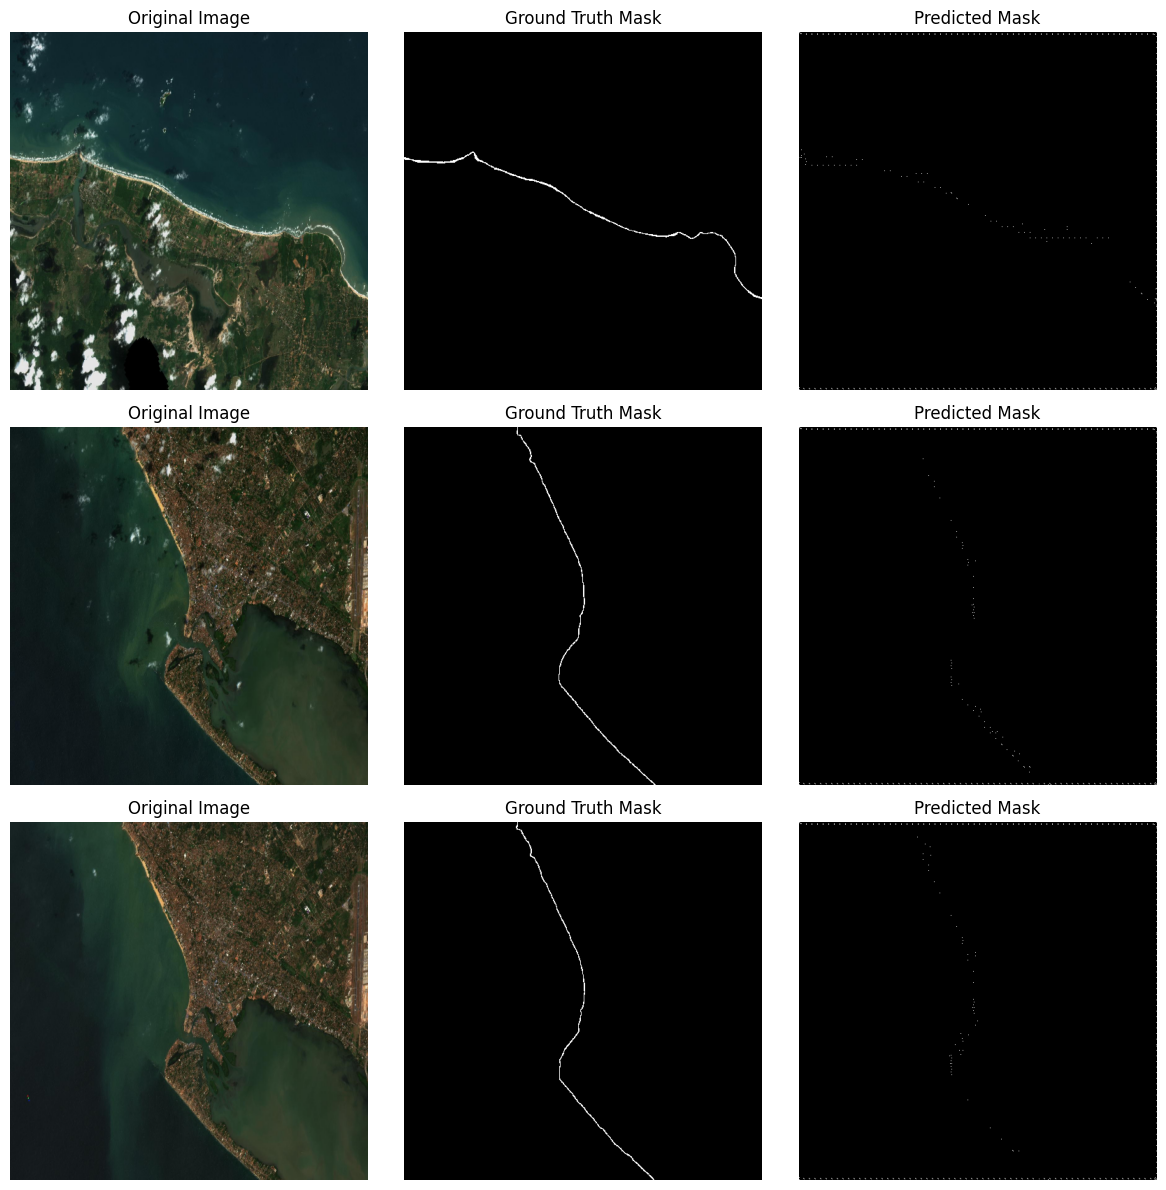

In [ ]:
display_predictions(model, test_ds, num_samples=3, threshold=0.5)
